   *«Самые выдающиеся успехи компаний зависят не столько от решений руководства, сколько от случайных движений всего рынка.»*

   -- Рольф Добелли

   *«Ядро, по-видимому, умерло. Оно будет перезапущено автоматически.»*

   -- jupyterhub

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Построим по этим данным модель для определения стоимости автомобилей с учётом качества предсказаний, и скорости их выдачи.

## Подготовка данных

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import r2_score
from math import sqrt

import lightgbm as lgb
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    accuracy_score
)
import matplotlib.pyplot as plt

import timeit
import time

In [3]:
data = pd.read_csv('/datasets/autos.csv')

Посмотрим на загружаемые данные.

In [4]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Для удобства переименуем названия столбцов. Кроме того попытаемся проанализировать, какие из признаков пригодятся для последующего анализа, а какие можно назвать избыточными.

In [5]:
data = data.rename(columns={'DateCrawled': 'date_d',       # дата скачивания анкеты из базы   [не важен]
                            'Price': 'price',              # цена (Евро)                      [целевой признак]
                            'VehicleType' : 'cuzov',       # тип автомобильного кузова        [важен]
                            'RegistrationYear' : 'year',   # год регистрации автомобиля       [важен?]
                            'Gearbox' : 'box',             # тип коробки передач              [важен]
                            'Power' : 'n',                 # мощность (л. с.)                 [важен]
                            'Model' : 'model',             # модель автомобиля                [важен]
                            'Kilometer' : 'km',            # пробег (км)                      [важен]
                            'RegistrationMonth' : 'month', # месяц регистрации автомобиля     [не важен?]
                            'FuelType' : 'fuel',           # тип топлива                      [важен?]
                            'Brand' : 'marka',             # марка автомобиля                 [важен]
                            'Repaired' : 'remont',         # была машина в ремонте или нет    [важен]
                            'DateCreated' : 'date_m',      # дата создания анкеты             [не важен]
                            'NumberOfPictures' : 'photo',  # количество фотографий автомобиля [не важен]
                            'PostalCode' : 'index',        # почтовый индекс пользователя     [не важен]
                            'LastSeen' : 'date_l'          # дата последней активности        [не важен]
                           })

Поскольку задачей данного анализа является разработать алгорим для не встраимового в сервис по продаже автомобилей, то у данного алгоритма на этапе предсказания не будет информации о датах скачивания анкеты из базы, количестве фотографий пользователя, почтовом индексе и дате последней активности. Важность информации о дате регистрации автомобиля (предположим, речь идёт о регистрациив ГИБДД) является спорной, но для определённости будем считать важным год, но не месяц регистрации.

Исключим избыточную информацию из данных.

In [6]:
data = data.drop(columns=['date_d', 'month', 'photo', 'index', 'date_l', 'date_m'])

Заменим отремонтированные автомобили на 1, неремонтированные автомобили на -1, те автомобили про которые нет информации о ремонте отметим 0 (полагаю, многие пользователи не будут точно знать о наличии ремонта, поэтому этот вариант будет доступен на этапе предсказания)

In [7]:
data.loc[data['remont'] == 'yes', 'remont'] = 1
data.loc[data['remont'] == 'no', 'remont'] = -1
data['remont'] = data['remont'].fillna(0)

Заметим, что данных об отремонтированных машинах всего 10%, что несколько странно для "сервиса по продаже автомобилей с пробегом".

In [8]:
data.loc[data['remont'] == 1, 'price'].count() / data['price'].count()

0.10174140514548395

Среди исходных данных почти в 10% не указан тип топлива и кузова, а в 5% не указан тип модели.

In [9]:
data['fuel'].value_counts(dropna=False) / data['price'].count()

petrol      0.610527
gasoline    0.278580
NaN         0.092827
lpg         0.014984
cng         0.001594
hybrid      0.000658
other       0.000576
electric    0.000254
Name: fuel, dtype: float64

In [10]:
data['model'].value_counts(dropna=False) / data['price'].count()

golf                  0.082490
other                 0.068914
3er                   0.055764
NaN                   0.055606
polo                  0.036871
                        ...   
i3                    0.000023
rangerover            0.000011
serie_3               0.000011
serie_1               0.000006
range_rover_evoque    0.000006
Name: model, Length: 251, dtype: float64

In [11]:
data['cuzov'].value_counts(dropna=False) / data['price'].count()

sedan          0.258084
small          0.225276
wagon          0.183893
NaN            0.105794
bus            0.081201
convertible    0.057011
coupe          0.045611
suv            0.033852
other          0.009278
Name: cuzov, dtype: float64

Присвоим отсутсвующим данным значение `other`.

In [12]:
data.loc[data['fuel'].isna(), 'fuel'] = 'other'
data.loc[data['model'].isna(), 'model'] = 'other'
data.loc[data['cuzov'].isna(), 'cuzov'] = 'other'

Кроме того, предположим, что машин без коробки передач не бывает.

In [13]:
data['box'].value_counts(dropna=False) / data['price'].count()

manual    0.756982
auto      0.187051
NaN       0.055967
Name: box, dtype: float64

In [14]:
#data = data.loc[data['box'].isna() == False]
data.loc[data['box'].isna(), 'box'] = 'other'

Существуют данные о бесплатных и сверх дешёвых автомобилях, предположим, что эти строки стали результатом некой технической ошибки и удалим их из дальнейшего рассмотрения.

In [15]:
data.loc[data['price'] < 50, 'price'].count() / data['price'].count()

0.03505667820830829

In [16]:
data = data.loc[data['price'] >= 50]

Существуют строки с автомобилями пониженой и наоборот, неоправданно завышенной (больше мощности самого мощного двигателя в мире) мощности. Также предположим, что автомобилей с такой мощностью быть не может и удалим такие данные из рассмотрения.

In [17]:
data.loc[(data['n'] < 20) | (data['n'] > 421), 'price'].count() / data['price'].count()

0.10694378644581308

In [18]:
data = data.loc[(data['n'] >= 20) & (data['n'] <= 421)]

Существуют машины поставленные на регистрацию в будущем или далёком прошлом. Оставим только те строки в которых указан год между 1960 и позжнейшей датой выгрузки.

In [19]:
data = data[(data['year'] > 1960) & (data['year'] < 2016)]

Обновим индексы и посмотрим на финальную форму наших данных.

In [20]:
data = data.reset_index(drop=True)

In [21]:
data.head(10)

,price,cuzov,year,box,n,model,km,fuel,marka,remont
0,18300,coupe,2011,manual,190,other,125000,gasoline,audi,1
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,-1
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,-1
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,1
5,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,-1
6,14500,bus,2014,manual,125,c_max,30000,petrol,ford,0
7,999,small,1998,manual,101,golf,150000,other,volkswagen,0
8,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,-1
9,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,1


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288649 entries, 0 to 288648
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   price   288649 non-null  int64 
 1   cuzov   288649 non-null  object
 2   year    288649 non-null  int64 
 3   box     288649 non-null  object
 4   n       288649 non-null  int64 
 5   model   288649 non-null  object
 6   km      288649 non-null  int64 
 7   fuel    288649 non-null  object
 8   marka   288649 non-null  object
 9   remont  288649 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 22.0+ MB


Можно заметить, что в указанных данных есть небольшая положительная кореляция между годом и ценой, чуть меньшая положительная кореляция между годом и мощностью, а также слабые отрицательные кореляции между пробегом и ценой и пробегом и годом.

In [23]:
data.corr()

,price,year,n,km,remont
price,1.000000,0.553674,0.509967,-0.389580,-0.256381
year,0.553674,1.000000,0.160948,-0.332481,-0.171726
n,0.509967,0.160948,1.000000,0.106698,-0.076860
km,-0.389580,-0.332481,0.106698,1.000000,0.106807
remont,-0.256381,-0.171726,-0.076860,0.106807,1.000000


array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'n'}>,
        <AxesSubplot:title={'center':'km'}>],
       [<AxesSubplot:title={'center':'remont'}>, <AxesSubplot:>]],
      dtype=object)

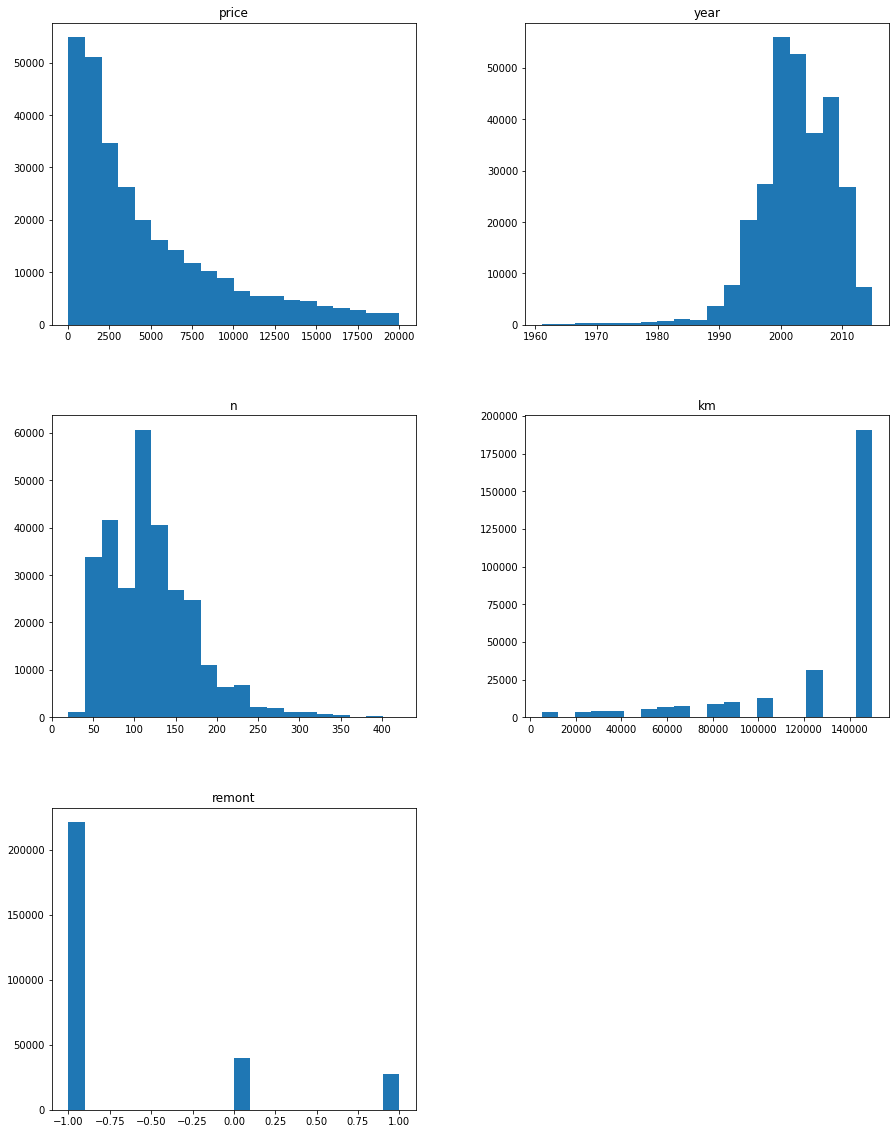

In [24]:
data.hist(bins=20, figsize=(15, 20), grid=False)

## Обучение моделей

Поскольку обучение работает только с типом данных `float`, приведём все данные к этому виду, используя метод порядкового кодирования при работе со строковыми данными.

In [25]:
df = data.drop(['cuzov', 'box', 'model', 'fuel', 'marka'], axis=1).astype(float)

In [26]:
encoder = OrdinalEncoder()
encoder.fit(data.loc[:, ['cuzov', 'box', 'model', 'fuel', 'marka']])
df = df.join(
    pd.DataFrame(encoder.fit_transform(data.loc[:, ['cuzov', 'box', 'model', 'fuel', 'marka']]), columns=['cuzov', 'box', 'model', 'fuel', 'marka'])
)

---

Целевым признаком в нашем исследовании является цена автомобиля. Отделим целевые признаки от нецелевых.

In [27]:
f = df.drop('price', axis=1)
t = df['price']

Разделим исходные данные на обучающую, валидационную и тестовую выборки в соотношение 3:1:1 (60%:20%:20%).

In [28]:
rrrr = 42 # random_state

# разбиение признаков
f_trn, f_vld, f_tst = \
              np.split(f.sample(frac=1, random_state=rrrr), 
                       [int(.6*len(f)), int(.8*len(f))])

# разбиение целевого признака
t_trn, t_vld, t_tst = \
              np.split(t.sample(frac=1, random_state=rrrr), 
                       [int(.6*len(t)), int(.8*len(t))])

Индексы у выборок совпадают.

In [29]:
f_trn.head(10)

,year,n,km,remont,cuzov,box,model,fuel,marka
213789,2004.0,82.0,150000.0,-1.0,6.0,1.0,160.0,4.0,16.0
264499,1997.0,75.0,150000.0,0.0,7.0,0.0,42.0,6.0,24.0
265339,1997.0,60.0,150000.0,-1.0,5.0,0.0,83.0,6.0,24.0
220275,2006.0,230.0,90000.0,-1.0,4.0,1.0,15.0,6.0,2.0
112644,2006.0,80.0,80000.0,-1.0,5.0,1.0,102.0,6.0,10.0
146311,2004.0,60.0,150000.0,-1.0,5.0,1.0,102.0,6.0,10.0
44848,2001.0,60.0,150000.0,1.0,5.0,1.0,246.0,6.0,17.0
20858,2007.0,218.0,150000.0,-1.0,6.0,0.0,166.0,2.0,14.0
276607,1996.0,136.0,150000.0,-1.0,4.0,1.0,95.0,6.0,20.0
142250,2006.0,105.0,150000.0,-1.0,7.0,1.0,42.0,6.0,24.0


In [30]:
t_trn.head(10)

213789     2490.0
264499      850.0
265339      700.0
220275    19900.0
112644     3000.0
146311      980.0
44848       200.0
20858     16500.0
276607     1700.0
142250     3450.0
Name: price, dtype: float64

---

### LightGBM

Также обучим модель методом `LightGBM`, для этого переберём модели с разным количеством деревьев и найдём лучшую из них.

In [31]:
lgb_train = lgb.Dataset(f_trn, t_trn)
lgb_eval = lgb.Dataset(f_vld, t_vld, reference=lgb_train)

b_gbm = None             # лучшая модель
r2 = 0                   # RMSE лучшей модели
for (i,j) in [(i,j) for i in range(28,33) for j in range(22,25)]:
    print(i,j)
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': i,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }

    start = timeit.default_timer()
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=j,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])
    end = timeit.default_timer()


    #p_trn = gbm.predict(f_trn, num_iteration=gbm.best_iteration)
    p_vld = gbm.predict(f_vld, num_iteration=gbm.best_iteration)
    #p_tst = gbm.predict(f_tst, num_iteration=gbm.best_iteration)
    
    if (r2 < sqrt(mean_squared_error(t_vld, p_vld))):
        b_gbm = gbm
        r2 = sqrt(mean_squared_error(t_vld, p_vld))
        t = end - start

print('Лучший:', r2)
print('Время (мс):', t)
#print(r2_score(t_trn, p_trn))
#print(r2_score(t_vld, p_vld))
#print(r2_score(t_tst, p_tst))

28 22
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.299657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[22]	valid_0's l2: 6.44858e+06	valid_0's l1: 1876.25
28 23
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.382362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's l2: 6.23345e+06	valid_0's l1: 1838.32
28 24
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.289047 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don'

### Случайный лес

Для нахождения лучшей модели случайного леса обучим несколько из них, перебирая параметры максимальной глубины и количества деревьев.

In [31]:
b_rfc = None             # лучшая модель
r2 = 0                   # RMSE лучшей модели

for (i,j) in [(i,j) for i in range(60,81,10) for j in range(4,8)]:
    print(i,j)
    m = RandomForestClassifier(
        random_state=rrrr,
        n_estimators=i,                      # обучаем модель с заданным количеством деревьев
        max_depth=j,                         # максимальная глубина
        class_weight='balanced'              # обучаем модель с взвешаннами классами
    )
    start = timeit.default_timer()
    m.fit(f_trn,t_trn)                       # тренируем модель по тренировочной выборке
    end = timeit.default_timer()
    p_vld = m.predict(f_vld)                 # предсказание результатов
    
    if (r2 < sqrt(mean_squared_error(t_vld, p_vld))):
        b_rfc = m
        r2 = sqrt(mean_squared_error(t_vld, p_vld))
        t = end - start

print('Лучший:', r2)
print('Время (мс):', t)

60 4
60 5
60 6
60 7
70 4
70 5
70 6
70 7
80 4
80 5
80 6
80 7
Лучший: 4646.264694118517
Время (мс): 4.894050872884691


## Анализ моделей

### LightGBM

Лучшая `LightGBM` модель даёт наилучшее среднеквадратичное отклонение для тестовых данных и сравнительно небольшое время предсказаний, скорость обучения этого метода оставляет желать лучшего, но она выше чем для модели случайного леса.

In [33]:
p_trn = b_gbm.predict(f_trn, num_iteration=gbm.best_iteration)
p_vld = b_gbm.predict(f_vld, num_iteration=gbm.best_iteration)
p_tst = b_gbm.predict(f_tst, num_iteration=gbm.best_iteration)
print(sqrt(mean_squared_error(t_trn, p_trn)))
print(sqrt(mean_squared_error(t_vld, p_vld)))
start = timeit.default_timer()
print(sqrt(mean_squared_error(t_tst, p_tst)))
end = timeit.default_timer()
print('Время (мс):', t)

2535.3226207596053
2539.405307946463
2535.022821709657
Время (мс): 4.909074227092788


### Случайный лес

Лучшая модель случайного леса обладает крайне низкой скоростью обучения и предсказания, кроме того данная модель обладает наименьшей точностью.

In [ ]:
p_trn = b_rfc.predict(f_trn)
p_vld = b_rfc.predict(f_vld)
p_tst = b_rfc.predict(f_tst)
print(sqrt(mean_squared_error(t_trn, p_trn)))
print(sqrt(mean_squared_error(t_vld, p_vld)))
start = timeit.default_timer()
print(sqrt(mean_squared_error(t_tst, p_tst)))
end = timeit.default_timer()
print('Время (мс):', t)

## Вывод

В ходе данного исследования были получены модели линейной `LightGBM` и случайного леса. В ходе анализа и обучения этих моделей было установлено, что наилучшей с точки зрения производительности и точности является модель `LightGBM`.